In [6]:
import random
import time
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

seed=42

In [2]:
words = open('names.csv', 'r').read().splitlines()
words = [s.lower() for s in words] 

#build vocabulary
special_token = '.'
def vocabulary(words):
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi[special_token] = 0
    itos = {i:s for s,i in stoi.items()}
    return stoi, itos, len(itos)

stoi, itos, vocab_size = vocabulary(words)
special_idx = stoi[special_token]

In [3]:
len(words), min(len(w) for w in words), max(len(w) for w in words)

(101338, 2, 15)

In [5]:
print(itos) #confirm dictionary makes sense

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
random.seed(seed)
random.shuffle(words)

# build dataset
block_size = 8 #how many chars to use in our prediction

def build_dataset(words):
    X, Y = [], [] #inputs and labels

    for w in words:
        context = [special_idx] * block_size #context starts as ". . ."
        for ch in w + special_token:
            ix = stoi[ch] # retrieve index for char from vocab
            X.append(context) #add current example, starting with ". . ."
            Y.append(ix) #the label is the next char (or first, or . for last)
            context = context[1:] + [ix] #cropping first char as window slides and another char is added

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'{X.shape=}, {Y.shape=}')
    
    return X, Y

train=0.8
dev=0.1
assert train + dev <= 1

n1 = int(train*len(words))
n2 = int((train+dev)*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

X.shape=torch.Size([610286, 8]), Y.shape=torch.Size([610286])
X.shape=torch.Size([76476, 8]), Y.shape=torch.Size([76476])
X.shape=torch.Size([76060, 8]), Y.shape=torch.Size([76060])


In [8]:
#what doe these look like?
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '==>', itos[y.item()])

........ ==> s
.......s ==> a
......sa ==> m
.....sam ==> e
....same ==> r
...samer ==> r
..samerr ==> a
.samerra ==> .
........ ==> c
.......c ==> a
......ca ==> l
.....cal ==> d
....cald ==> o
...caldo ==> n
..caldon ==> i
.caldoni ==> a
caldonia ==> .
........ ==> m
.......m ==> u
......mu ==> d


In [24]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # karmin initialization
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training = True
        # trained parameters
        self.gamma = torch.ones(dim) #controls amplitude of each dimenstion x*1, 1 is neutral
        self.beta = torch.zeros(dim) #adds a bias x+0, 0 is neutral
        # buffers, "trained" with momentum update, not really a param
        self.running_var = torch.ones(dim)
        self.running_mean = torch.zeros(dim)

    def __call__(self, x):
        #basically forward pass
        if self.training:
            if x.ndim == 2: dim = 0
            elif x.ndim == 3: dim = (0,1)
            xmean = x.mean(dim, keepdim=True) #batch mean
            xvar = x.var(dim, keepdim=True)
        else:
            xmean, xvar = self.running_mean, self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        
        return self.out
    
    def parameters(self):
        return[self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B,T,C = x.shape #batch_size, block_size (tokens), embedding_size
        #keep batch the same, flatten embeddings side by side by window size
        x = x.view(B, T//self.n, C*self.n) 
        if x.shape[1] == 1: x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        for p in self.parameters():
            p.requires_grad = True
        print(f'model created with { sum(p.nelement() for p in self.parameters())} parameters')

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        #get parameters for all layers inside and flatten into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [25]:
torch.manual_seed(seed)

#hierarchical network
n_embd = 24 #dimensionality of character embeddings
n_hidden = 128 #if think this works best if it's a multiple of cnn_size
flatten = 2
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(flatten), Linear(n_embd*flatten, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(flatten), Linear(n_hidden*flatten, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(flatten), Linear(n_hidden*flatten, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

model created with 76579 parameters


In [26]:
max_steps = 200_000
batch_size = 32
lossi = []
parameters = model.parameters() #cache parameters

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update weights
    lr = 0.1 if i < max_steps * 2/3 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    #stats
    if i % (max_steps/20) == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 3.8348
  10000/ 200000: 2.0654
  20000/ 200000: 2.6878
  30000/ 200000: 2.2260
  40000/ 200000: 2.3431
  50000/ 200000: 2.5247
  60000/ 200000: 2.3540
  70000/ 200000: 1.6319
  80000/ 200000: 2.1782
  90000/ 200000: 1.8362
 100000/ 200000: 1.7809
 110000/ 200000: 1.9375
 120000/ 200000: 1.9400
 130000/ 200000: 1.9142
 140000/ 200000: 1.7733
 150000/ 200000: 1.9389
 160000/ 200000: 1.7546
 170000/ 200000: 2.1653
 180000/ 200000: 1.9617
 190000/ 200000: 1.6727


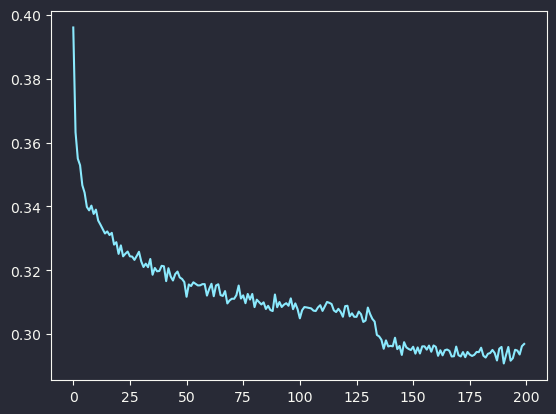

In [27]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [28]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [31]:
#test loss on dev set
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9592472314834595
val 2.011403799057007


In [32]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1) #softmax over 1st dim, which is chars
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item() # sammple
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


isaia.
lathaleesa.
reness.
merion.
mahlise.
nyhunra.
jannis.
jroswa.
sanriea.
andil.
kendray.
lareea.
tyressa.
marves.
jollyn.
kamiria.
taxan.
eliane.
lilien.
kistia.
